# Denoising
## Import necessary libraries

In [1]:
import os
import gc
import pywt 
import feather
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import scipy
from scipy import signal
from scipy.signal import butter, deconvolve
from numpy.fft import *
import matplotlib.pyplot as plt
from utils import generate_segment_start_ids, compare_methods
from statsmodels.robust import mad
%matplotlib inline
warnings.filterwarnings('ignore')

### Read data

In [2]:
# The computed features are saved in an hdf file along with the time_to_failure to 
# save the time spend reading the training data and the feature computation
#train_data_format = 'csv'
train_data_format = 'feather'

In [3]:
def load_train_data(file_format):
    """Load the training dataset."""
    print(f"Loading data from {file_format} file:", end="")
    if file_format.lower() == 'feather':
        train_df = feather.read_dataframe('../input/train.feather')
    else:
        train_df = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16,
                                                            'time_to_failure': np.float32})
        feather.write_dataframe(train_df, '../input/train.feather')
    print("Done")
    return train_df

In [4]:
train = load_train_data(train_data_format)

Loading data from feather file:Done


### Cut out segments of size 150k from the signal

In [5]:
fs = 4000000 #Sampling frequency of the raw signal
#Compute features for the training data
segment_size = 150000
signals = []
segment_start_ids = generate_segment_start_ids('uniform_no_jump', segment_size, train)
for idx in tqdm_notebook(range(len(segment_start_ids))):        
    seg_id = segment_start_ids[idx]
    seg = train.iloc[seg_id:seg_id + segment_size]
    signals.append(seg)

### The mean absolute deviation
This calculates the mean of the absolute values of the deviations of the individual numbers in the time series from the mean of the time series. It is a measure of entropy or disorder in the time series. The greater the MAD value, the more disorderly and unpredictable the time series is.

In [6]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [7]:
def high_pass_filter(x, low_cutoff, SAMPLE_RATE):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * SAMPLE_RATE
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

In [8]:
def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

In [9]:
#Compute features for the training data
signals_hpf_denoise = []
signals_wavelet_denoise = []
signals_combined_denoise = []
for i in tqdm_notebook(range(4178)):
    ss = pd.Series(seg['acoustic_data'].values.astype('float64'))
    signals_hpf_denoise.append(high_pass_filter(ss, low_cutoff=10000, SAMPLE_RATE=fs))
    signals_wavelet_denoise.append(denoise_signal(ss))
    signals_combined_denoise.append(denoise_signal(high_pass_filter(ss, low_cutoff=10000, SAMPLE_RATE=fs), wavelet='haar', level=1))

### Visualize the effect of high-pass filter and wavelet denoising on seismic signals

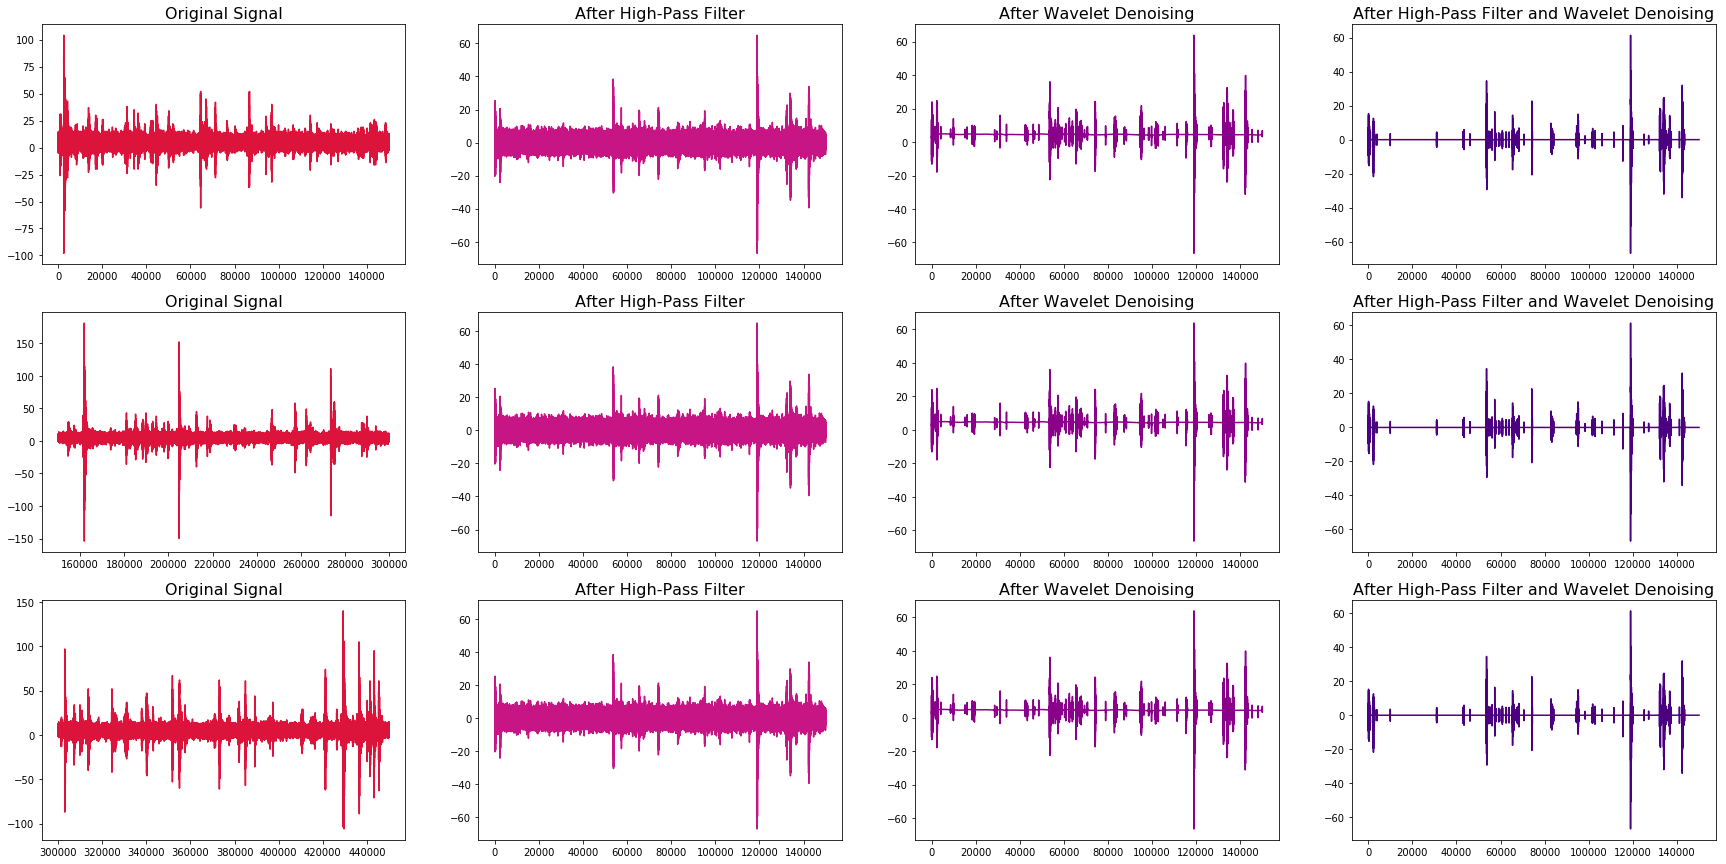

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))

ax[0, 0].plot(signals[0], 'crimson') 
ax[0, 0].set_title('Original Signal', fontsize=16)
ax[0, 1].plot(signals_hpf_denoise[0], 'mediumvioletred') 
ax[0, 1].set_title('After High-Pass Filter', fontsize=16)
ax[0, 2].plot(signals_wavelet_denoise[0], 'darkmagenta')
ax[0, 2].set_title('After Wavelet Denoising', fontsize=16)
ax[0, 3].plot(signals_combined_denoise[0], 'indigo')
ax[0, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

ax[1, 0].plot(signals[1], 'crimson') 
ax[1, 0].set_title('Original Signal', fontsize=16)
ax[1, 1].plot(signals_hpf_denoise[1], 'mediumvioletred') 
ax[1, 1].set_title('After High-Pass Filter', fontsize=16)
ax[1, 2].plot(signals_wavelet_denoise[1], 'darkmagenta')
ax[1, 2].set_title('After Wavelet Denoising', fontsize=16)
ax[1, 3].plot(signals_combined_denoise[1], 'indigo')
ax[1, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

ax[2, 0].plot(signals[2], 'crimson') 
ax[2, 0].set_title('Original Signal', fontsize=16)
ax[2, 1].plot(signals_hpf_denoise[2], 'mediumvioletred') 
ax[2, 1].set_title('After High-Pass Filter', fontsize=16)
ax[2, 2].plot(signals_wavelet_denoise[2], 'darkmagenta')
ax[2, 2].set_title('After Wavelet Denoising', fontsize=16)
ax[2, 3].plot(signals_combined_denoise[2], 'indigo')
ax[2, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

plt.show()